In [5]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet101
import pandas as pd
import numpy as np

In [2]:
base_dir = './data/cats_and_dogs'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# train collection
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# validation collection
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [12]:
batch_size = 32
img_height = 64
img_width = 64

In [14]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=32
)

validation_ds = keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=(64, 64),
    batch_size=batch_size
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [15]:
class_names = train_ds.class_names
class_names

['cats', 'dogs']

In [6]:
# get pretrain model
pre_trained_model = ResNet101(
    input_shape = (img_height, img_width, 3), # 输入大小
    include_top = False, # 不要最后的全连接层
    weights = 'imagenet')

171450368/171446536 [==============================] - 6s 0us/step


In [7]:
# we don't need to train the pre trained model
for layer in pre_trained_model.layers:
    layer.trainable = False

In [10]:
# train

num_classes = 2

# 为全连接层准备
x = keras.layers.Flatten()(pre_trained_model.output)
# 加入全连接层，这个需要重头训练的
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)                  
# 输出dense层
keras.layers.Dense(512, activation='relu'),
keras.layers.Dense(num_classes),         
# 构建模型序列
model = keras.Model(pre_trained_model.input, x) 

model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer='adam', 
    metrics=['acc'])

In [16]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=20,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]
)

Epoch 1/20
63/63 [==============================] - 41s 585ms/step - loss: 4.6812 - acc: 0.5603 - val_loss: 1.8294 - val_acc: 0.7740
Epoch 2/20
63/63 [==============================] - 51s 813ms/step - loss: 2.2887 - acc: 0.7533 - val_loss: 1.2702 - val_acc: 0.7930
Epoch 3/20
63/63 [==============================] - 39s 622ms/step - loss: 2.3589 - acc: 0.7489 - val_loss: 1.4563 - val_acc: 0.7970
Epoch 4/20
63/63 [==============================] - 37s 587ms/step - loss: 1.9010 - acc: 0.7705 - val_loss: 1.3959 - val_acc: 0.7870
Epoch 5/20
63/63 [==============================] - 37s 581ms/step - loss: 1.8696 - acc: 0.7951 - val_loss: 2.0573 - val_acc: 0.7800
Epoch 6/20
63/63 [==============================] - 37s 587ms/step - loss: 1.7500 - acc: 0.8261 - val_loss: 1.4097 - val_acc: 0.8070
Epoch 7/20
63/63 [==============================] - 37s 577ms/step - loss: 1.5555 - acc: 0.8348 - val_loss: 1.5260 - val_acc: 0.7950


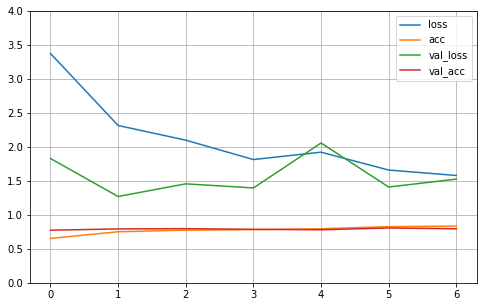

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5), grid=True, ylim=(0, 4))

In [24]:
# predict
cat_test_path = './test/cat/cat_test.JPG'
img = keras.preprocessing.image.load_img(
    cat_test_path, target_size=(img_width, img_height)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


f"This image most likely belongs to {class_names[np.argmax(score)]} with a {100 * np.max(score)} percent confidence."

'This image most likely belongs to cats with a 99.94763731956482 percent confidence.'